In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 

In [2]:
# Get all longIn files and create a single dataframe with all of them
df = pd.DataFrame()
for file in os.listdir('./features/'):
    # Get desired files and exclude the one that doesnt have matching cpu values
    if(file.startswith('longIn') and
       not file == 'longIn9_m_0.025_i_20.0.csv'):
        df = df.append(pd.read_csv('./features/'+file, delimiter=' '))

# Fix dataset
columns_labels = list(df.columns.values)
for j in range(len(columns_labels)-1, 61, -1):
    df[columns_labels[j]] = df[columns_labels[j-1]]

del df['flowsOther']
df.rename(columns={'Unnamed: 47':'numOthersL4'}, inplace=True)

print(df.shape)
df.head(5)

(453, 87)


,%batchNum,lastTS,numPackets,totalBytes,avgInterAT,stdInterAT,avgLength,stdLength,ipSrc,ipDst,...,avgLengthFlowOther,stdLengthFlowOther,onePacketFlows,httpPackets,httpFlows,sslPackets,sslFlows,smtpPackets,smtpFlows,auxFet
0,1,500020,46139,37979756,10.843608,13.327500,833.029237,672.701827,3321,1206,...,148.426136,607.526837,3198,28356,2822,471,106,85,19,0
1,2,1000013,45229,36009167,11.064634,13.307693,805.369565,677.025301,3244,1252,...,276.696970,1840.677036,3177,27878,2808,448,85,83,21,0
2,3,1500007,44969,35011269,11.127556,13.400585,787.560329,677.776996,3342,1226,...,127.476471,403.320825,3280,27501,3007,428,90,59,22,0
3,4,2000013,45509,36617871,10.991845,13.390374,813.325567,674.585671,3378,1222,...,181.056818,908.773974,3247,28125,2980,490,100,40,14,0
4,5,2500005,44116,34044043,11.338186,13.277443,777.357324,679.399498,3325,1148,...,290.013793,1655.864793,3073,26501,2809,448,93,53,13,0


In [3]:
# list of labels with [] 
lst = [x for x in df.columns.values if '[' in x]
df = df.drop(lst, axis=1)
df = df.drop(['%batchNum','lastTS', 'avgLength', 'stdLength',
              'ipSrc', 'ipDst', 'srcPortTCP',
              'dstPortTCP', 'srcPortUDP', 'dstPortUDP',
              'ipSrcPort', 'ipDstPort', 'httpPackets',
              'httpFlows', 'sslPackets', 'sslFlows',
              'smtpPackets', 'smtpFlows', 'auxFet', 
              'ipSrcDst','numPackets', 'tcpSyn',
              'tcpFin', 'tcpRes', 'avgLengthFlowTCP',
              'stdLengthFlowTCP', 'avgLengthFlowUDP',
              'stdLengthFlowUDP', 'avgLengthFlowOther',
              'stdLengthFlowOther', 'ipv4', 'ipv6', 'onePacketFlows',
              'avgInterAtFlowUDP', 'stdInterAtFlowUDP',
              'avgInterAtFlowOther', 'stdInterAtFlowOther'], axis=1)
print(df.columns.values)
print(len(df.columns.values))

['totalBytes' 'avgInterAT' 'stdInterAT' 'icmp4' 'icmp6' 'numTCP' 'numUDP'
 'numOthersL4' 'othersL4' 'flows' 'flowsTCP' 'flowsUDP'
 'avgPacketsFlowTCP' 'stdPacketsFlowTCP' 'avgPacketsFlowUDP'
 'stdPacketsFlowUDP' 'avgPacketsFlowOther' 'stdPacketsFlowOther'
 'avgInterAtFlowTCP' 'stdInterAtFlowTCP']
20


In [4]:
correlation = df.corr()
#print(correlation)
labels_x = correlation.columns.values
labels_y = correlation.index.values
corr = correlation.to_numpy()
#print(corr)
rows = corr.shape[0]
columns = corr.shape[1]
for i in range(rows):
    for j in range(columns):
        corr_value = corr[i][j]
        x = labels_x[i] 
        y = labels_y[j]
        if corr_value > 0.9 and not(x==y):
            print("{} x {} :{}".format(x,y,corr_value))

totalBytes x numTCP :0.9531706090279715
avgInterAT x stdInterAT :0.9836245736444967
stdInterAT x avgInterAT :0.9836245736444967
numTCP x totalBytes :0.9531706090279715


No handles with labels found to put in legend.
No handles with labels found to put in legend.


(453, 20)
(453,)
396.67328918322295
41.3220177881228
(440, 20)
(440,)


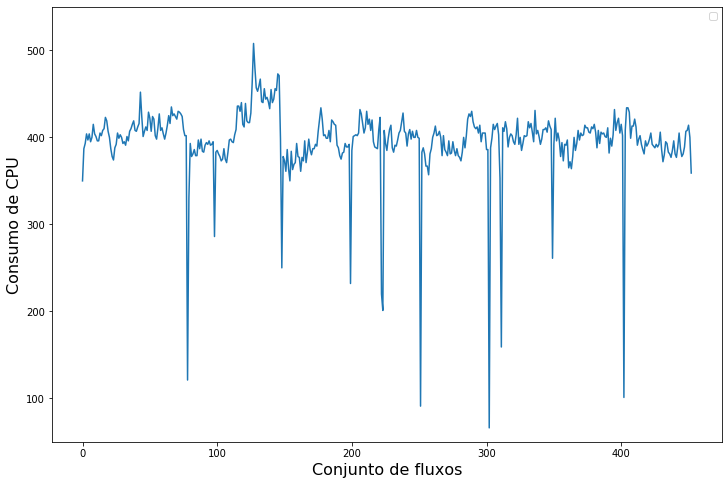

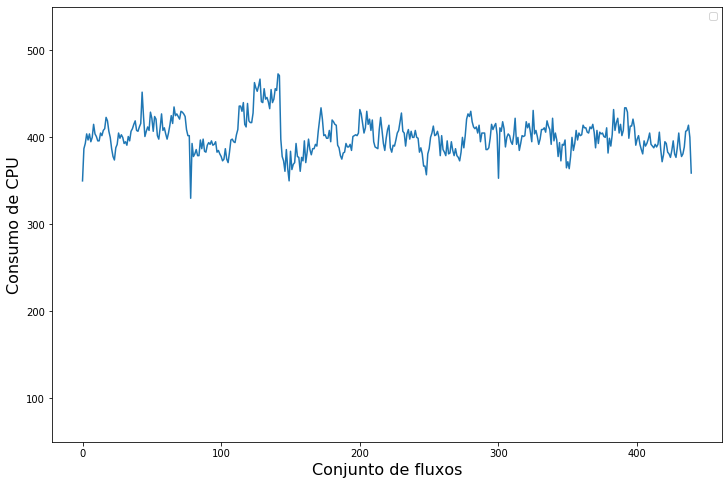

In [6]:
from sklearn import svm, metrics, tree,preprocessing
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

X = df.to_numpy()
Y = np.empty
for file in os.listdir('./cpu/'):
    if(file.startswith('longIn')):
        Y = np.append(Y,np.loadtxt('./cpu/'+file))
# Clean First parameter ("<built-in function empty>")
Y = Y[1:]
print(X.shape)
print(Y.shape)

mean, std = np.mean(Y), np.std(Y)
print(mean)
print(std)
Y_pre_outlier_removal = np.copy(Y)

for index in range(len(Y)-1,0, -1):
    cpu_use = Y[index]
    if (cpu_use < mean - 2*std or cpu_use > mean + 2*std):
        Y = np.delete(Y, index)
        X = np.delete(X, index, 0)
        

print(X.shape)
print(Y.shape)



plt.figure(figsize=(12,8))

axes = plt.gca()
axes.set_ylim([50,550])
plt.xlabel('Conjunto de fluxos', fontsize=16)
plt.ylabel('Consumo de CPU', fontsize=16)
plt.plot(Y_pre_outlier_removal)
plt.legend()


plt.figure(figsize=(12,8))
axes = plt.gca()
axes.set_ylim([50,550])
plt.xlabel('Conjunto de fluxos', fontsize=16)
plt.ylabel('Consumo de CPU', fontsize=16)
plt.plot(Y)
plt.legend()

trainData, testData, trainLabels, testLabels = train_test_split(
                                    X, Y, test_size = (0.2), random_state = 1)

min_max_scaler = preprocessing.MinMaxScaler()
trainData = min_max_scaler.fit_transform(trainData)
testData = min_max_scaler.transform(testData)


In [7]:
def display_results(y_pred, testLabels):
    print("-"*20)
    print("Predicted values:")
    print(y_pred)
    print("Real values:")
    print(testLabels)
    print("-"*20)
    mae = metrics.mean_absolute_error(testLabels, y_pred)
    mse = metrics.mean_squared_error(testLabels, y_pred)
    r2 = metrics.r2_score(testLabels, y_pred)
    print("Mean absolute error: " + str(mae))
    print("Mean square error: " + str(mse))
    print("R2 score:" + str(r2))
    
    
    plt.plot(range(len(testLabels)),testLabels, label='Real Values')
    plt.plot(range(len(y_pred)), y_pred, label='Predicted Values')
    plt.xlabel('Conjunto de fluxos', fontsize=16)
    plt.ylabel('Consumo de CPU', fontsize=16)    
    plt.legend()
    plt.figure(figsize=(12,8))

DecisionTreeRegressor()
--------------------
Predicted values:
[404. 387. 403. 403. 383. 396. 392. 393. 384. 387. 377. 407. 388. 408.
 389. 392. 398. 379. 411. 403. 361. 401. 388. 398. 405. 405. 408. 421.
 377. 435. 413. 397. 357. 408. 378. 406. 415. 385. 374. 402. 382. 390.
 398. 418. 390. 453. 408. 408. 419. 385. 350. 457. 383. 408. 384. 412.
 387. 379. 396. 435. 427. 390. 379. 402. 401. 373. 401. 402. 404. 387.
 378. 412. 401. 402. 377. 417. 385. 405. 425. 414. 389. 409. 377. 392.
 441. 385. 408. 378.]
Real values:
[410.0 406.0 421.0 353.0 389.0 383.0 412.0 372.0 405.0 397.0 400.0 403.0
 396.0 395.0 427.0 400.0 417.0 407.0 388.0 383.0 397.0 404.0 406.0 372.0
 405.0 402.0 423.0 387.0 383.0 421.0 383.0 377.0 405.0 395.0 367.0 456.0
 373.0 393.0 400.0 405.0 385.0 386.0 390.0 428.0 380.0 434.0 421.0 395.0
 405.0 392.0 416.0 392.0 399.0 393.0 391.0 402.0 382.0 330.0 385.0 421.0
 386.0 425.0 415.0 392.0 405.0 395.0 422.0 444.0 403.0 373.0 400.0 391.0
 432.0 411.0 408.0 392.0 415.0 386.0 3

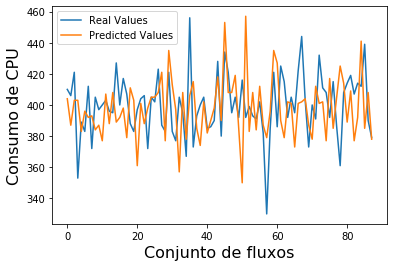

<Figure size 864x576 with 0 Axes>

In [8]:
tree_model = tree.DecisionTreeRegressor()
tree_model.fit(trainData, trainLabels)

print(tree_model)
y_pred = tree_model.predict(testData)


display_results(y_pred, testLabels)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
--------------------
Predicted values:
[412.1 411.7 394.8 403.4 389.1 403.6 421.7 388.  401.  392.8 398.3 402.
 388.6 403.  410.9 404.9 399.8 403.7 399.2 405.  399.  403.5 428.1 398.
 382.5 408.6 405.4 398.1 408.  400.5 417.5 403.2 384.5 410.7 380.7 425.7
 394.3 405.5 399.2 402.6 382.8 410.  402.1 402.7 401.3 407.4 409.9 406.5
 406.3 388.  394.4 393.1 409.4 393.  390.5 404.7 394.4 395.3 398.5 403.3
 407.  396.9 409.2 393.1 398.7 399.2 411.8 414.3 407.  389.8 401.2 398.
 400.6 397.9 390.7 416.5 402.  380.8 387.8 418.  400.3 395.5 397.3 402.4
 412.8 408.3 402.8 398.1]
Real values:
[410.0 406.0 421.

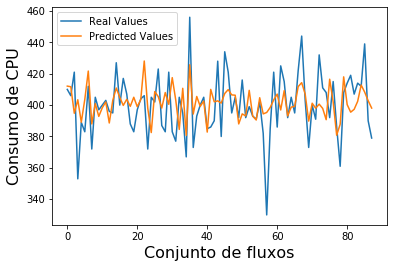

<Figure size 864x576 with 0 Axes>

In [14]:
rf_model = RandomForestRegressor(n_estimators=10)
rf_model = rf_model.fit(trainData, trainLabels)

print(rf_model.get_params())
y_pred = rf_model.predict(testData)

display_results(y_pred, testLabels)

In [ ]:
print(metrics.SCORERS.keys())

{'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 16, 'n_estimators': 200}
--------------------
Predicted values:
[404.92151164 394.43922048 403.81581466 398.06454549 395.28847416
 400.83625231 408.53646085 404.13516486 399.10179363 395.51396942
 400.30950276 402.17374684 397.11822525 408.68741716 406.93903515
 396.88480838 403.94932131 400.617293   393.86507538 406.03871283
 401.20984178 402.78979993 403.9154183  400.56075047 387.79749586
 399.92495854 403.81782217 395.67549985 397.63577332 395.94105227
 392.15915181 397.01975394 402.23733302 401.42591864 383.51125938
 411.16341656 396.67789518 398.23140092 399.59518346 398.45908335
 379.9737435  410.76893904 401.09740391 400.17039228 399.27915756
 400.02382605 410.86086388 405.63874313 406.14365554 395.9376673
 409.8449889  407.95300032 404.08817452 398.33010023 394.33484195
 395.33129819 398.45655995 400.26201406 402.35711878 403.10798287
 406.12104786 402.38688137 400.26965025 397.54385694 400.1865754

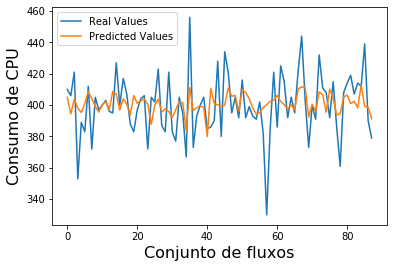

<Figure size 864x576 with 0 Axes>

In [12]:
gb_model = GradientBoostingRegressor()
params = {
    'loss': ('ls', 'lad', 'huber', 'quantile'),
    'learning_rate': [0.05,0.1,0.3],
    'n_estimators': [100, 150, 200],
    'max_depth': [8, 16, 24],
    'criterion': ('friedman_mse', 'mse')
}

gb_model = GridSearchCV(gb_model, params,scoring='r2')
gb_model.fit(trainData, trainLabels)

print(gb_model.best_params_)
y_pred = gb_model.predict(testData)

display_results(y_pred, testLabels)


{'base_estimator': DecisionTreeRegressor(max_depth=6), 'learning_rate': 0.5, 'loss': 'linear', 'n_estimators': 200}
--------------------
Predicted values:
[409.5        402.33333333 401.6        404.         389.69565217
 406.8125     411.66666667 392.70588235 394.07142857 382.57142857
 405.16666667 401.76923077 389.71428571 401.6        408.46153846
 393.94736842 405.62068966 397.         397.3164557  417.70634921
 403.40740741 404.06557377 404.         400.4        395.88888889
 400.13888889 402.8        387.82352941 396.07692308 396.
 392.         394.81818182 386.72727273 407.57894737 395.17948718
 414.         401.80645161 401.46956522 399.18085106 401.80645161
 384.5        398.87058824 401.22727273 396.8        400.1875
 401.25       412.         403.75       405.31428571 396.67567568
 396.19047619 399.33333333 407.36666667 399.25       391.66666667
 394.57894737 394.30769231 398.33333333 399.16176471 406.19277108
 400.         403.         409.14876033 399.16176471 402.03333333

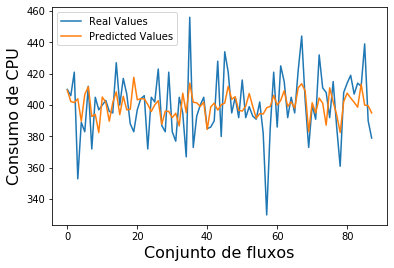

<Figure size 864x576 with 0 Axes>

In [13]:
ab_model = AdaBoostRegressor(learning_rate=0.01, n_estimators=100, loss='square')

params = {
    'loss': ('square', 'exponential', 'linear'),
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'n_estimators': [50,100,150,200,250],
    'base_estimator': (tree.DecisionTreeRegressor(max_depth=3),
                       tree.DecisionTreeRegressor(max_depth=6),
                       tree.DecisionTreeRegressor(max_depth=9),
                       tree.DecisionTreeRegressor(max_depth=12)
                      )
}

ab_model = GridSearchCV(ab_model, params,scoring='r2')

ab_model.fit(trainData, trainLabels)

print(ab_model.best_params_)
y_pred = ab_model.predict(testData)

display_results(y_pred, testLabels)
